Neste notebook, iremos classificar compostos como ativos ou inativos frente a topoisomerases I e II, um importante alvo para o desenvolvimento de quimioterápicos.

Os compostos foram previamente baixados no ChemBL (https://www.ebi.ac.uk/chembl/), e todos exibem certa atividade contra essas enzimas. Iremos utilizar a estrutura SMILES de cada composto para calcular descritores moleculares. Para isso, precisaremos tratar (consideravelmente) os dados.

Precisaremos instalar p RDKit, que não estão pré-instalados no Colab.

In [ ]:
! pip install rdkit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.3/34.3 MB 16.0 MB/s eta 0:00:00


Em seguida, importaremos as bibliotecas essenciais.
Também importaremos métodos clássicos de ML para classificação, como o DummyClassifier e o Random Forest.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import rdkit

from rdkit import Chem
from rdkit.Chem import Descriptors

from tensorflow import keras
from tensorflow.keras import layers

from sklearn.model_selection import train_test_split, cross_val_score

from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc


Começaremos lendo os dados, já pré-processados

In [ ]:
df = pd.read_excel("entrada_dados.xlsx")

In [ ]:
df

,Smiles,pChEMBL Value,Status
0,Br.CC[C@@H](Nc1ncnc2[nH]c(-c3ccc(O)cc3)cc12)c1...,8.40,Active
1,Br.COc1cc(OC)cc(N(CCP(=O)(O)O)c2ccc3ncc(-c4cnn...,7.66,Active
2,Br.C[C@@H](Nc1ncnc2[nH]c(-c3ccc(O)cc3)cc12)c1c...,8.42,Active
3,Br.C[C@@H](Nc1ncnc2[nH]c(-c3ccc(O)cc3)cc12)c1c...,8.05,Active
4,Br.C[C@@H](Nc1ncnc2[nH]c(-c3ccc(O)cc3)cc12)c1c...,8.10,Active
...,...,...,...
38713,c1ncc(s1)-c1cnc2cc(ccn12)-c1ccccc1,7.00,Active
38714,c1nn2cc(cnc2c1-c1ccccc1)-c1ccccn1,7.06,Active
38715,c1nn2cc(cnc2c1-c1ccccc1)-c1ccncc1,7.15,Active
38716,c1nn2cc(cnc2c1-c1ccncc1)-c1ccncc1,6.65,Active


Precisamos conferir se as estruturas SMILES estão corretas.

In [ ]:
def is_valid_smiles(smiles):
  smiles = str(smiles)
  mol = Chem.MolFromSmiles(smiles)
  return mol is not None

df = df[df['Smiles'].apply(is_valid_smiles)]

[18:38:15] Explicit valence for atom # 31 N, 4, is greater than permitted
[18:38:16] Explicit valence for atom # 32 N, 4, is greater than permitted
[18:38:16] Explicit valence for atom # 27 N, 4, is greater than permitted
[18:38:17] Explicit valence for atom # 20 N, 4, is greater than permitted
[18:38:18] Explicit valence for atom # 9 C, 5, is greater than permitted
[18:38:18] Explicit valence for atom # 19 H, 2, is greater than permitted
[18:38:18] Explicit valence for atom # 35 N, 4, is greater than permitted
[18:38:19] Can't kekulize mol.  Unkekulized atoms: 41 42 43 44 45
[18:38:19] Can't kekulize mol.  Unkekulized atoms: 30 31 33 34 47
[18:38:20] Can't kekulize mol.  Unkekulized atoms: 17 18 19 20 21 22 23 24 34
[18:38:20] Explicit valence for atom # 4 N, 4, is greater than permitted
[18:38:20] Explicit valence for atom # 11 N, 4, is greater than permitted
[18:38:21] Explicit valence for atom # 31 N, 4, is greater than permitted
[18:38:21] Explicit valence for atom # 25 N, 4, is g

A seguir, calcularemos descritores moleculares com base na estrutura SMILES. Para isso, usaremos o RDKit.
Escolhemos os descritores mais comuns; o RDKit permite o cálculo de cerca de 200 descritores.

In [ ]:
def calcular_descritores(smiles):
    mol = Chem.MolFromSmiles(smiles)
    descritores_selecionados = {
        'MolLogP': Descriptors.MolLogP,
        'MolWt': Descriptors.MolWt,
        'TPSA': Descriptors.TPSA,
        'FractionCSP3': Descriptors.FractionCSP3,
        'NumHDonors': Descriptors.NumHDonors,
        'NumHAcceptors': Descriptors.NumHAcceptors,
        'NumAromaticRings': Descriptors.NumAromaticRings,
        'NumRotatableBonds': Descriptors.NumRotatableBonds
    }

    resultados = {}
    if mol is not None:
        for nome_descritor, funcao_descritor in descritores_selecionados.items():
            resultados[nome_descritor] = funcao_descritor(mol)

    return resultados

descritores = df['Smiles'].apply(calcular_descritores)

df_descritores = pd.DataFrame(descritores.tolist())

df_resultado = pd.concat([df.reset_index(drop=True), df_descritores.reset_index(drop=True)], axis=1)

df_resultado = df_resultado[['Smiles', 'pChEMBL Value', 'Status', 'MolLogP', 'MolWt', 'TPSA', 'FractionCSP3', 'NumHDonors', 'NumHAcceptors', 'NumAromaticRings', 'NumRotatableBonds']]

Podemos verificar nossos dados até então.

In [ ]:
df_resultado = df_resultado[['Smiles', 'Status', 'pChEMBL Value', 'MolLogP', 'MolWt', 'TPSA', 'FractionCSP3', 'NumHDonors', 'NumHAcceptors', 'NumAromaticRings', 'NumRotatableBonds']] #, 'LE', 'BEI', 'SEI', 'NSEI', 'NBEI', 'LipE', 'LLE']]

In [ ]:
df_resultado

,Smiles,Status,pChEMBL Value,MolLogP,MolWt,TPSA,FractionCSP3,NumHDonors,NumHAcceptors,NumAromaticRings,NumRotatableBonds
0,Br.CC[C@@H](Nc1ncnc2[nH]c(-c3ccc(O)cc3)cc12)c1...,Active,8.40,5.4716,425.330,73.83,0.142857,3,4,4,5
1,Br.COc1cc(OC)cc(N(CCP(=O)(O)O)c2ccc3ncc(-c4cnn...,Active,7.66,3.9412,550.350,122.83,0.227273,2,8,4,8
2,Br.C[C@@H](Nc1ncnc2[nH]c(-c3ccc(O)cc3)cc12)c1c...,Active,8.42,5.2206,429.293,73.83,0.100000,3,4,4,4
3,Br.C[C@@H](Nc1ncnc2[nH]c(-c3ccc(O)cc3)cc12)c1c...,Active,8.05,5.2206,429.293,73.83,0.100000,3,4,4,4
4,Br.C[C@@H](Nc1ncnc2[nH]c(-c3ccc(O)cc3)cc12)c1c...,Active,8.10,5.2206,429.293,73.83,0.100000,3,4,4,4
...,...,...,...,...,...,...,...,...,...,...,...
38683,c1ncc(s1)-c1cnc2cc(ccn12)-c1ccccc1,Active,7.00,4.1248,277.352,30.19,0.000000,0,4,4,2
38684,c1nn2cc(cnc2c1-c1ccccc1)-c1ccccn1,Active,7.06,3.4583,272.311,43.08,0.000000,0,4,4,2
38685,c1nn2cc(cnc2c1-c1ccccc1)-c1ccncc1,Active,7.15,3.4583,272.311,43.08,0.000000,0,4,4,2
38686,c1nn2cc(cnc2c1-c1ccncc1)-c1ccncc1,Active,6.65,2.8533,273.299,55.97,0.000000,0,5,4,2


Converteremos os dados para arrays. Como o Keras só trata dados numéricos, iremos definir um composto ativo (=1) e inativo (=0).

In [ ]:
X = df_resultado[['MolLogP', 'MolWt', 'TPSA', 'FractionCSP3', 'NumHDonors', 'NumHAcceptors', 'NumAromaticRings', 'NumRotatableBonds']]# 'LE', 'BEI', 'SEI', 'NSEI', 'NBEI', 'LipE', 'LLE']]
df_resultado['Status2'] = df_resultado['Status'].apply(lambda x: 1 if x == "Active" else 0)
y = df_resultado['Status2']

X = np.array(X)
y = np.array(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)



Definimos, compilamos e fitamos o modelo no Keras.

In [ ]:
model = keras.Sequential([
    layers.Dense(32, activation="relu"),
    layers.Dense(32, activation="relu"),
    layers.Dense(32, activation="relu"),
    layers.Dense(1, activation="sigmoid")
])

In [ ]:
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])

In [ ]:
history = model.fit(X_train,
                    y_train,
                    epochs=30,
                    batch_size=64,
                    validation_data=(X_val, y_val))

Epoch 1/30
454/454 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.6710 - loss: 2.1184 - val_accuracy: 0.6732 - val_loss: 0.6652
Epoch 2/30
454/454 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.7375 - loss: 0.5936 - val_accuracy: 0.7530 - val_loss: 0.6169
Epoch 3/30
454/454 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7433 - loss: 0.5685 - val_accuracy: 0.3287 - val_loss: 0.7286
Epoch 4/30
454/454 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7446 - loss: 0.5546 - val_accuracy: 0.7229 - val_loss: 0.5996
Epoch 5/30
454/454 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7514 - loss: 0.5411 - val_accuracy: 0.7608 - val_loss: 0.5188
Epoch 6/30
454/454 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7533 - loss: 0.5365 - val_accuracy: 0.7591 - val_loss: 0.5441
Epoch 7/30
454/454 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.7532 - loss: 0.5365 - val_accuracy: 0.7577 - val_loss: 0.5494
Epoch 8/30
454/454 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7533 - loss: 0.5362 - val_accuracy: 0.

Agora plotamos a acurácia e a perda do modelo ao longo das épocas.

In [ ]:
history_dict = history.history
history_dict.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

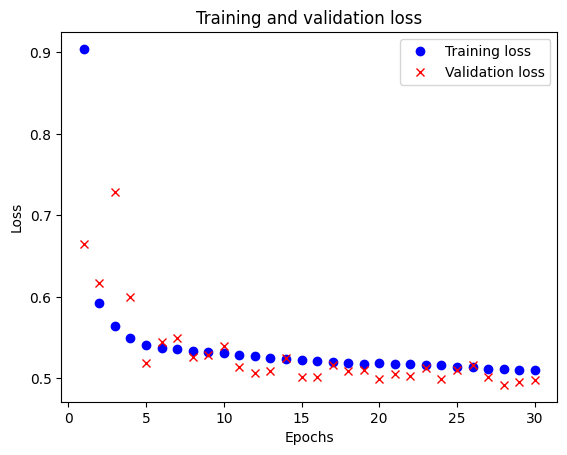

In [ ]:
history_dict = history.history
loss_values = history_dict["loss"]
val_loss_values = history_dict["val_loss"]
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, "bo", label="Training loss")
plt.plot(epochs, val_loss_values, "rx", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

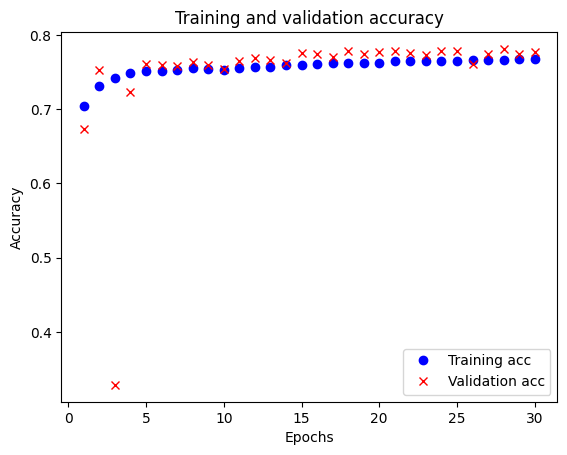

In [ ]:
plt.clf()
acc = history_dict["accuracy"]
val_acc = history_dict["val_accuracy"]
plt.plot(epochs, acc, "bo", label="Training acc")
plt.plot(epochs, val_acc, "rx", label="Validation acc")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

Para fazer um paralelo com as redes neurais, vamos utilizar outros dois modelos com o scikit-learn: o DummyClassificar e Random Forest.

In [ ]:
X = df_resultado[['MolLogP', 'MolWt', 'TPSA', 'FractionCSP3', 'NumHDonors', 'NumHAcceptors', 'NumAromaticRings', 'NumRotatableBonds']]#, 'LE', 'BEI', 'SEI', 'NSEI', 'NBEI', 'LipE', 'LLE']]
y = df_resultado['Status']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

dummy_clf = DummyClassifier(strategy='stratified', random_state=42)

dummy_clf.fit(X_train, y_train)

cv_scores = cross_val_score(dummy_clf, X_train, y_train, cv=5)

y_pred = dummy_clf.predict(X_test)

accuracy_dc = accuracy_score(y_test, y_pred)
precision_dc = precision_score(y_test, y_pred, average='weighted')
recall_dc = recall_score(y_test, y_pred, average='weighted')
f1_dc = f1_score(y_test, y_pred, average='weighted')

print(f"Accuracy: {accuracy_dc}")
print(f"Precision: {precision_dc}")
print(f"Recall: {recall_dc}")
print(f"F1 Score: {f1_dc}")

Accuracy: 0.619453777892651
Precision: 0.6187104755955607
Recall: 0.619453777892651
F1 Score: 0.6190810818731607


In [ ]:
X = df_resultado[['MolLogP', 'MolWt', 'TPSA', 'FractionCSP3', 'NumHDonors', 'NumHAcceptors', 'NumAromaticRings', 'NumRotatableBonds']]#, 'LE', 'BEI', 'SEI', 'NSEI', 'NBEI', 'LipE', 'LLE']]
y = df_resultado['Status']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

rf_clf = RandomForestClassifier(random_state=42)

rf_clf.fit(X_train, y_train)

cv_scores = cross_val_score(rf_clf, X_train, y_train, cv=5)

y_pred = rf_clf.predict(X_test)

accuracy_rf = accuracy_score(y_test, y_pred)
precision_rf = precision_score(y_test, y_pred, average='weighted')
recall_rf = recall_score(y_test, y_pred, average='weighted')
f1_rf = f1_score(y_test, y_pred, average='weighted')

print(f"Accuracy (RandomForest): {accuracy_rf}")
print(f"Precision (RandomForest): {precision_rf}")
print(f"Recall (RandomForest): {recall_rf}")
print(f"F1 Score (RandomForest): {f1_rf}")

Accuracy (RandomForest): 0.8439734642887913
Precision (RandomForest): 0.836821182948865
Recall (RandomForest): 0.8439734642887913
F1 Score (RandomForest): 0.8356196245208447
